# Prova 1

In [1]:
# Fazer os imports das bibliotecas necessarias 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.style as stl
import scipy.signal as sg
from PIL import Image
import glob
stl.use('default')
PI = np.pi

### Exercicio 1

##### a) Identificar a Sequencia de Teclas Ativadas com base na visualização do Espectograma 

Antes de Executar o código, tem que fazer o upload do arquivo de audio da prova para o COLAB

In [2]:
#Importar o sinal de audio para o python
sinal , taxa_amostragem = sf.read('audio_prova1.wav')
periodo = 1/taxa_amostragem
#Criando nosso vetor Tempo
time = np.arange(0,len(sinal)*periodo , periodo)

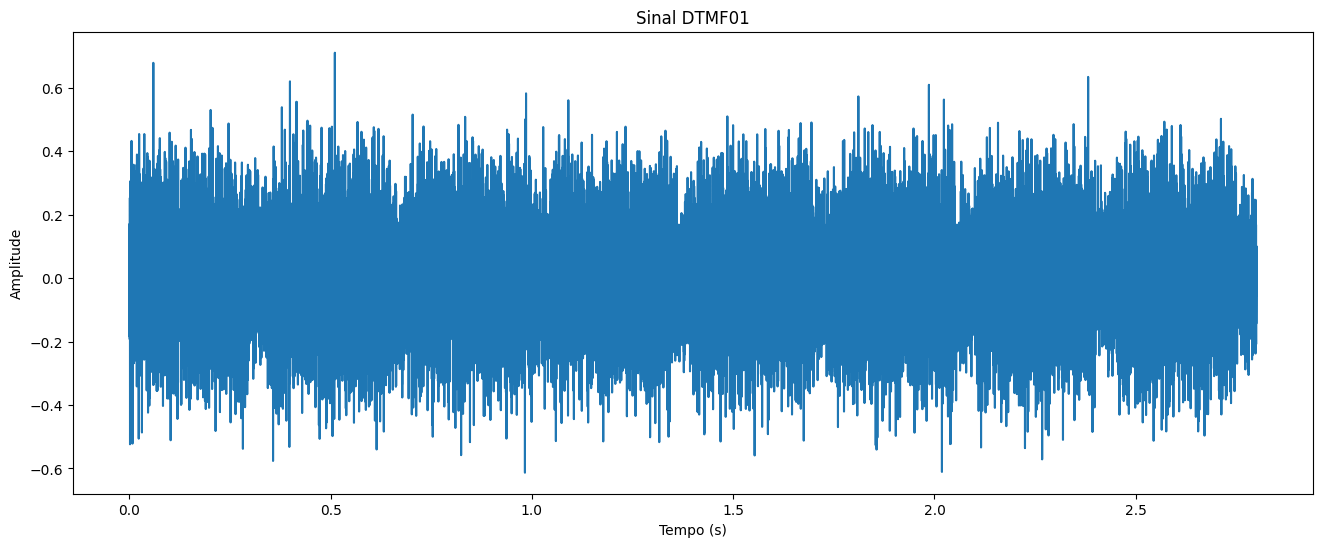

In [3]:
#Plotando o sinal com ruido no dominio Tempo
plt.figure(figsize=(16,6))
plt.title("Sinal DTMF01")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.plot(time,sinal)
plt.show()

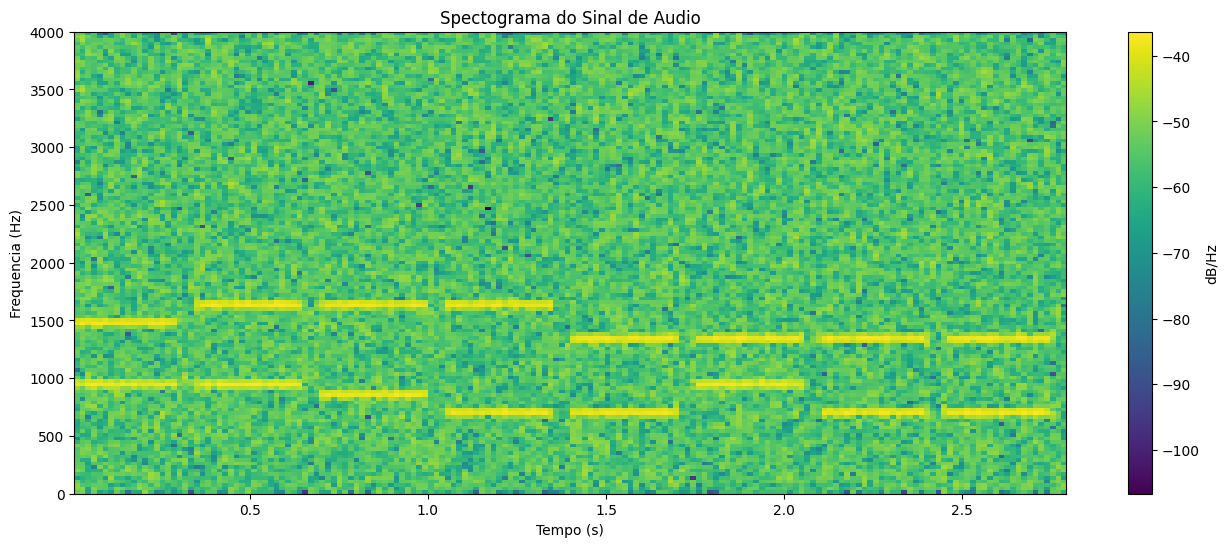

In [4]:
#Plotando o Espectograma do sinal
plt.figure(figsize=(16,6))
plt.specgram(sinal,Fs=taxa_amostragem)
plt.title("Spectograma do Sinal de Audio")
plt.xlabel("Tempo (s)")
plt.ylabel("Frequencia (Hz)")
plt.colorbar(label="dB/Hz")
plt.show()

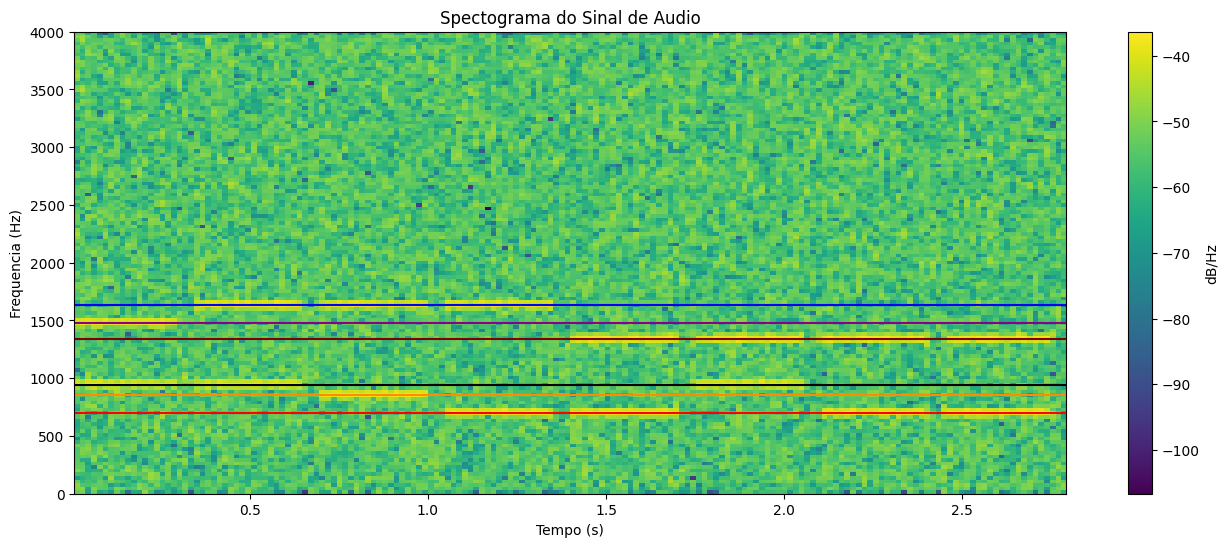

In [5]:
#Plotando o Espectograma do sinal com a identificação de linhas nas frequencias estudadas
plt.figure(figsize=(16,6))
plt.specgram(sinal,Fs=taxa_amostragem)
plt.axhline(y=697, xmin=0, xmax=len(sinal)*periodo , color='red')
plt.axhline(y=852, xmin=0, xmax=len(sinal)*periodo , color='#FF8C00')
plt.axhline(y=941, xmin=0, xmax=len(sinal)*periodo , color='black')
plt.axhline(y=1336, xmin=0, xmax=len(sinal)*periodo , color='#800000')
plt.axhline(y=1477, xmin=0, xmax=len(sinal)*periodo , color='#8B008B')
plt.axhline(y=1633, xmin=0, xmax=len(sinal)*periodo , color='blue')
plt.title("Spectograma do Sinal de Audio")
plt.xlabel("Tempo (s)")
plt.ylabel("Frequencia (Hz)")
plt.colorbar(label="dB/Hz")
plt.show()

In [6]:
# Criando uma funcao para retornar a tecla digitada com base nas 2 frequencias encontradas em um determinado momento 
def encontrar_tecla(freq_menor , freq_maior):
  Matriz_Teclas = np.array([[1,2,3,"A"],[4,5,6,"B"],[7,8,9,"C"],["*",0,"#","D"]])

  freq_linhas = [697,770,852,941]
  freq_colunas = [1209,1336,1477,1633] 

  linha = freq_linhas.index(freq_menor)
  coluna = freq_colunas.index(freq_maior)
  
  return Matriz_Teclas[linha][coluna]

In [7]:
# Armazenando em um vetor as duplas de frequencias encontradas no spectograma
frequencias_encontradas = np.array([
  [941,1477],
  [941,1633],
  [852,1633],
  [697,1633],
  [697,1336],
  [941,1336],
  [697,1336],
  [697,1336]])

teclas_acionadas = []
for i in frequencias_encontradas:
  teclas_acionadas.append(encontrar_tecla(i[0],i[1]))

teclas_acionadas # vetor contendo as teclas acionadas

['#', 'D', 'C', 'A', '2', '0', '2', '2']

Com base na figura das teclas e os dados contidos nela (frequencia por linhas e colunas), 
conseguimos mapear as teclas pelo par de frequencias caracteristico da tecla.Com o espectograma criado, podemos dizer qual foram as teclas pressionadas, ja que as duas frequencias caracteristicas do clique ficam evidentes pela amplitude (a cor fica mais quente).A sequencia de teclas pressionada foi # D C A 2 0 2 2

#### b) Detectar/Estimar os tempos de ocorrencia do acionamento de cada tecla

Para detectar o evento clique da tecla, vamos utilizar da matriz do espectograma que nos vai retornar as energias em cada linha de frequencia.
Fazendo essa soma das linhas da matriz, temos a energia correspondente em cada instante de tempo t

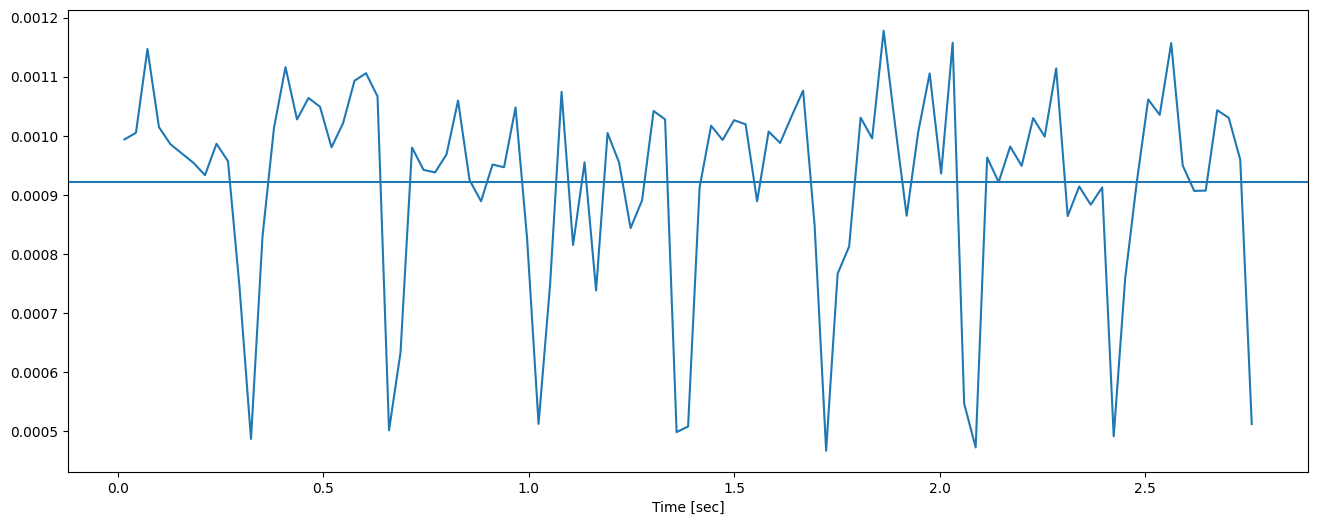

In [8]:
f, t, Sxx = sg.spectrogram(sinal, taxa_amostragem)
energy = Sxx.sum(axis=0)
potencia_media_aproximada = np.sum(energy)/len(t) #Calculo da Potencia Media

plt.figure(figsize=(16,6))
plt.plot(t,energy)
plt.axhline(potencia_media_aproximada , xmin= 0 , xmax=t[len(t)-1])
plt.xlabel('Time [sec]')
plt.show()  


Como foi visto, traçamos uma aproximação da potencia media do nosso sinal e percebemos que tem umas oscilações que não representam exatamente a coreencia de um clique ou não.Para isso vamos tratar os dados para ter algo mais representativo. 

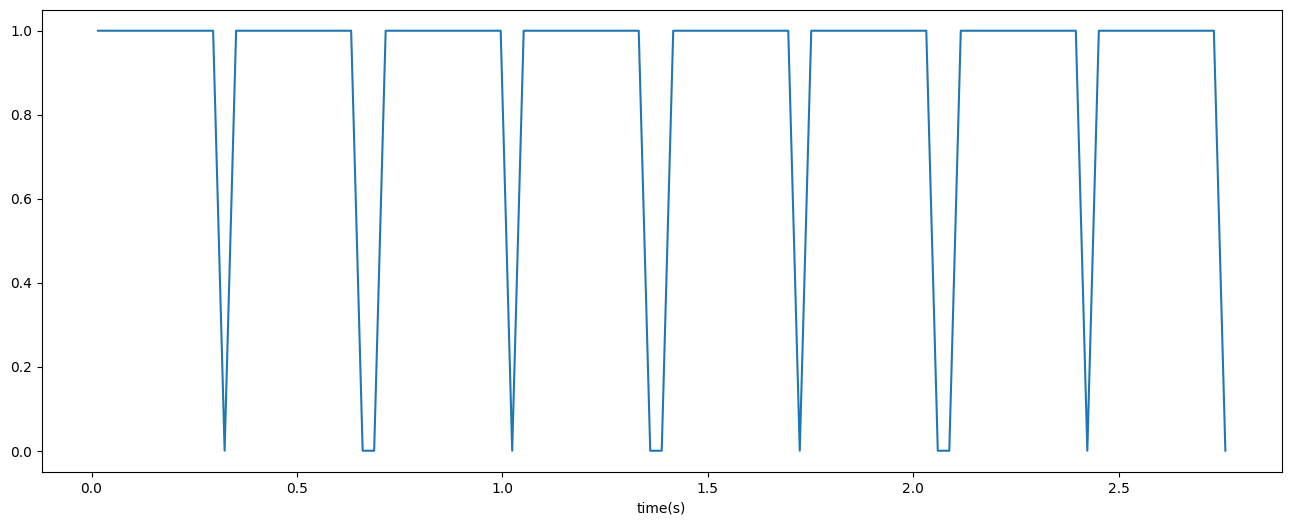

In [9]:
#vetor contendo as distancias de cada ponto a potencia media
distancia_da_media = ((energy - potencia_media_aproximada)/potencia_media_aproximada)*100

# Pegamos o vetor de distancia media e onde temos uma diferença inferior a -30% consideramos que ela nao esta pressionada, caso contrario esta pressionado
distancia_da_media[distancia_da_media < -30 ] = 0
distancia_da_media[distancia_da_media != 0 ] = 1

# Plotamos o grafico tratado
plt.figure(figsize=(16,6))
plt.plot(t,distancia_da_media)
plt.xlabel("time(s)")
plt.show()

Com dados mais simples de observar, podemos agora criar nossos vetores de tempos em que teve um clique e tempo que largou o clique

In [10]:
tempos_iniciais = [t[0]]
tempos_finais = [] 
pressionado = True
for i in range(1,len(t) , 1):
  if distancia_da_media[i] == 0 and pressionado :
    pressionado = False
    tempos_finais.append(t[i])
  elif distancia_da_media[i] == 1 and pressionado == False:
    pressionado = True
    tempos_iniciais.append(t[i])

tempo_acionadas = np.array(tempos_finais) - np.array(tempos_iniciais)


print(tempos_iniciais)
print(tempos_finais)
print(tempo_acionadas)
  


[0.016, 0.352, 0.716, 1.052, 1.416, 1.752, 2.116, 2.452]
[0.324, 0.66, 1.024, 1.36, 1.724, 2.06, 2.424, 2.76]
[0.308 0.308 0.308 0.308 0.308 0.308 0.308 0.308]


In [11]:
for i in range(len(teclas_acionadas)):
  print("Tecla {} ficou pressionada por {} segundos".format(teclas_acionadas[i],tempo_acionadas[i]))


Tecla # ficou pressionada por 0.308 segundos
Tecla D ficou pressionada por 0.30800000000000005 segundos
Tecla C ficou pressionada por 0.30800000000000005 segundos
Tecla A ficou pressionada por 0.30800000000000005 segundos
Tecla 2 ficou pressionada por 0.30800000000000005 segundos
Tecla 0 ficou pressionada por 0.30800000000000005 segundos
Tecla 2 ficou pressionada por 0.30799999999999983 segundos
Tecla 2 ficou pressionada por 0.30799999999999983 segundos


#### c) Implementar algum processo para recuperar o sinal(tratar o ruido)

Para tratarmos o ruido e recuperarmos o nosso sinal, no dominio tempo essa tarefa é muito dificil, então levaremos para o dominio frequencia e enchergaremos com mais facilidade o que é ruido e o que é o sinal desejado 

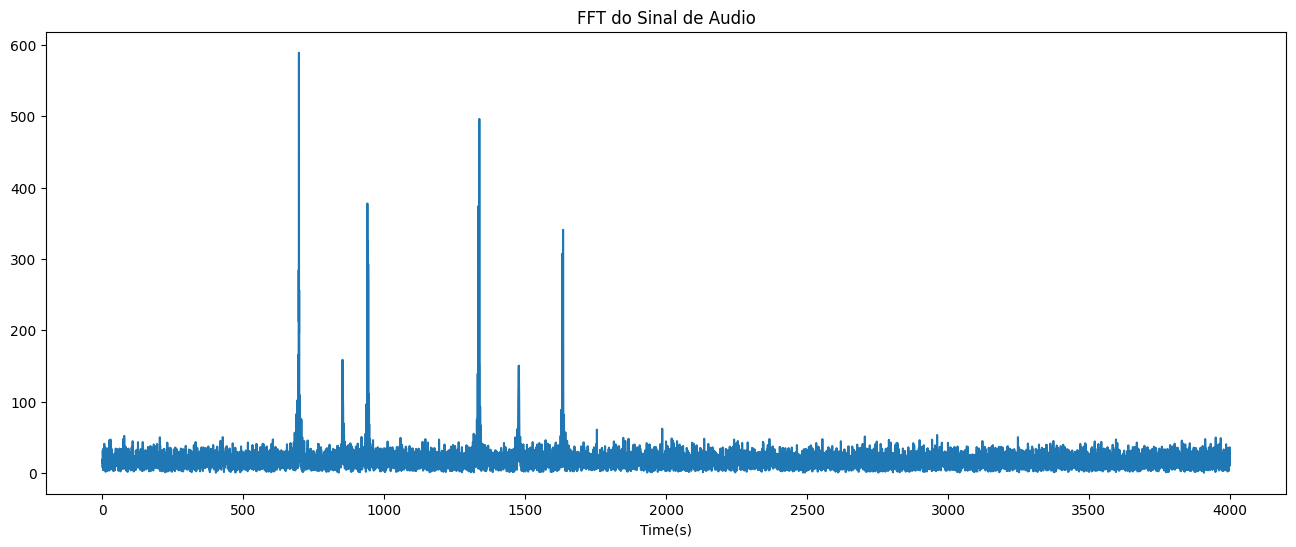

In [56]:
sinal_fft = np.fft.fft(sinal) # Aplicando a fft no nosso sinal
fft_freq = np.fft.fftfreq(len(sinal) , periodo) # Coletando as frequencias
mask = fft_freq >=0

plt.figure(figsize=(16,6))
plt.plot(fft_freq[mask] , np.abs(sinal_fft[mask]))
plt.title("FFT do Sinal de Audio")
plt.xlabel("Time(s)")
plt.show()

Com o espectograma feito na questão a) vimos que no nosso sinal temos 6 frequencias importantes e que se destacam das outras frequencias pelas suas cores mais quentes, ou seja a amplitude ser maior que nas outras frequencias.Então a estratégia para recuperar o sinal será de zerar os sinais de frequencia com amplitude menor que de um valor considerado.Após isso aplicar a inversa da fft para voltarmos ao dominio tempo com nosso sinal filtrado.

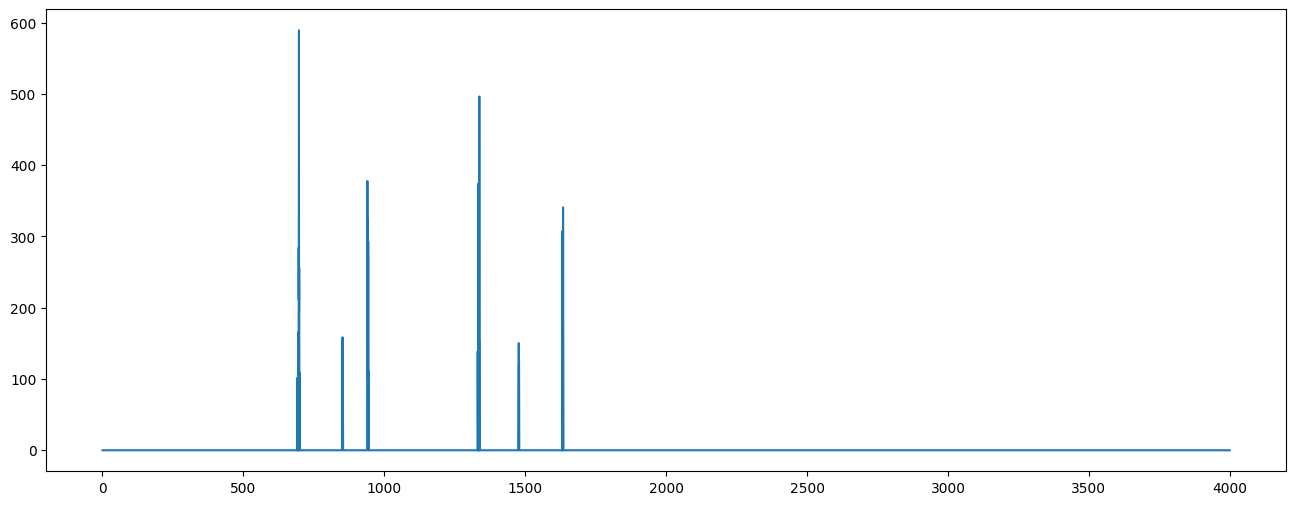

In [57]:
#Definimos a amplitude de corte em 100 , entao zeramos o resto
sinal_fft[np.abs(sinal_fft) < 100 ] = 0
plt.figure(figsize=(16,6))
plt.plot(fft_freq[mask] , np.abs(sinal_fft[mask]))
plt.show()

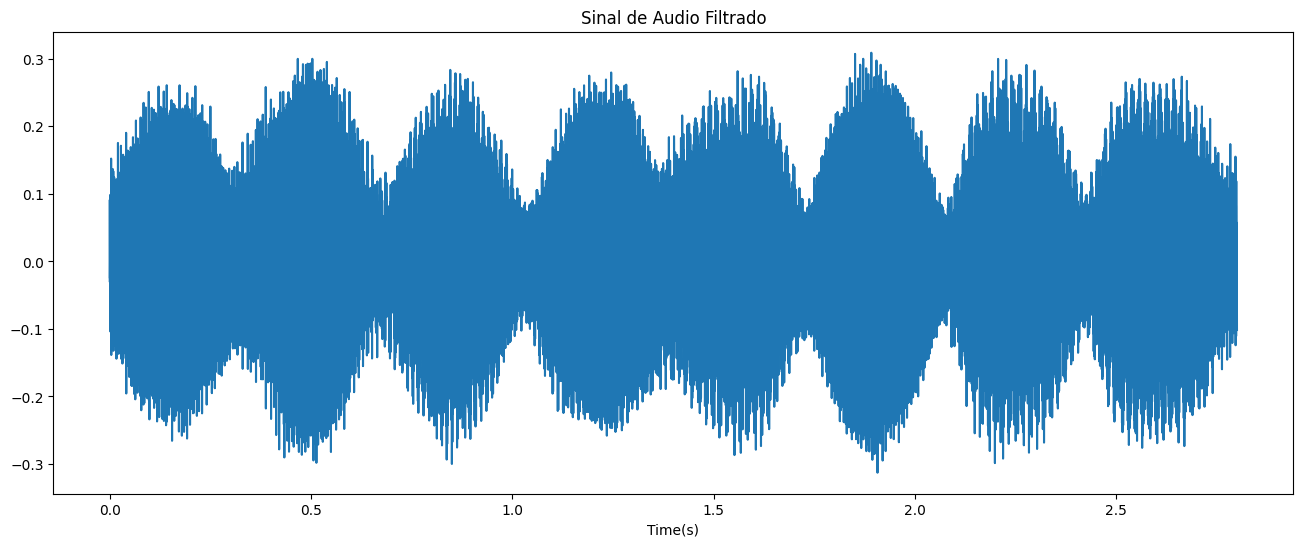

In [58]:
#Voltando para o dominio tempo e plotando o sinal
sinal_filtrado = np.fft.ifft(sinal_fft).real
plt.figure(figsize=(16,6))
plt.plot(time,sinal_filtrado)
plt.title("Sinal de Audio Filtrado")
plt.xlabel("Time(s)")
plt.show()

In [59]:
# Criando um arquivo de Audio com o audio filtrado
sf.write('audio_filtrado.wav',sinal_filtrado,taxa_amostragem)

Outro algoritmo de filtro visto em sala de aula:

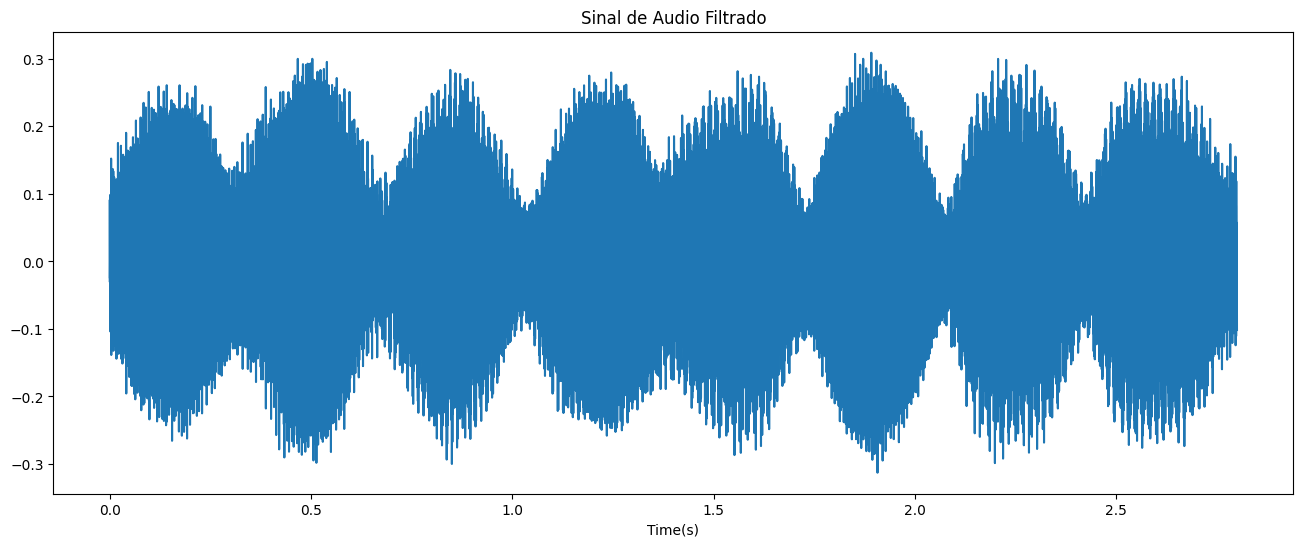

In [16]:
YRecov = np.fft.fft(sinal)
Mag = np.abs(YRecov)
Phase = np.angle(YRecov)
Mag[0] = 0
Mag[Mag < 100] = 0
Yrecov = Mag * np.exp(1j * Phase)
xRecov = np.fft.ifft(Yrecov)
plt.figure(figsize=(16,6))
plt.plot(time , xRecov.real)
plt.title("Sinal de Audio Filtrado")
plt.xlabel("Time(s)")
plt.show()

array([  0.        ,   0.        ,   0.        , ..., 496.33156905,
       589.18640573, 589.18640573])

### Exercicio 2

#### a) Utilizando uma frequencia de amostragem de 3110 Hz seria o adequado para a aplicação de DFTM ?

Não, pois de acordo com o teorema da amostragem, a nossa frequencia de amostragem tem que ser pelo menos 2x maior que a frequencia do fenomeno que estamos estudando.Como estamos estudando sobre a sinalização DTMF, a maior frequencia encontrada nessa sinalização é a de 1633Hz, isso significa que nossa frequencia de amostragem tem que ser de pelo menos 2*1633 Hz , ou seja , maior ou igual a 3266 Hz.

#### b) Determinar a sequencia de Caracteres usando uma frequência de amostragem de 3110 Hz

In [17]:
#Produzindo sinal de acordo com cada tecla
def sinal_tecla(Letra , taxa_amostragem , duracao ):
  if Letra == None:
    return np.arange(0,duracao , 1/taxa_amostragem)*0
    
  Matriz_Teclas = np.array([[1,2,3,"A"],[4,5,6,"B"],[7,8,9,"C"],["*",0,"#","D"]])

  freq_linhas = [697,770,852,941]
  freq_colunas = [1209,1336,1477,1633] 

  pos_letra = np.where(Matriz_Teclas == Letra)
  freq_menor = freq_linhas[pos_letra[0][0]]
  freq_maior = freq_colunas[pos_letra[1][0]]
  
  tempo = np.arange(0,duracao , 1/taxa_amostragem)

  sinal = 0.3 *(np.sin(2*PI*freq_menor*tempo) + np.sin(2*PI*freq_maior*tempo))
  return sinal

In [18]:
# produzindo uma funcao para gerar um sinal de #dca2022 dando como parametro a taxa de amostragem
def sinal_dca(taxa_amostragem):
  # Produzindo sinal separado de algumas teclas
  hashtag = sinal_tecla('#' , taxa_amostragem , 0.35)
  d = sinal_tecla('D' , taxa_amostragem , 0.35)
  c = sinal_tecla('C' , taxa_amostragem , 0.35)
  a = sinal_tecla('A' , taxa_amostragem , 0.35)
  n2 = sinal_tecla('2' , taxa_amostragem , 0.35)
  n0 = sinal_tecla('0' , taxa_amostragem , 0.35)
  d_t = sinal_tecla(None , taxa_amostragem , 1/8) # Intervalo entre sinais das teclas
  # produzindo sinal 
  result = np.concatenate((hashtag,d_t,d,d_t,c,d_t,a,d_t,n2,d_t,n0,d_t,n2,d_t,n2) , axis=0)
  return result

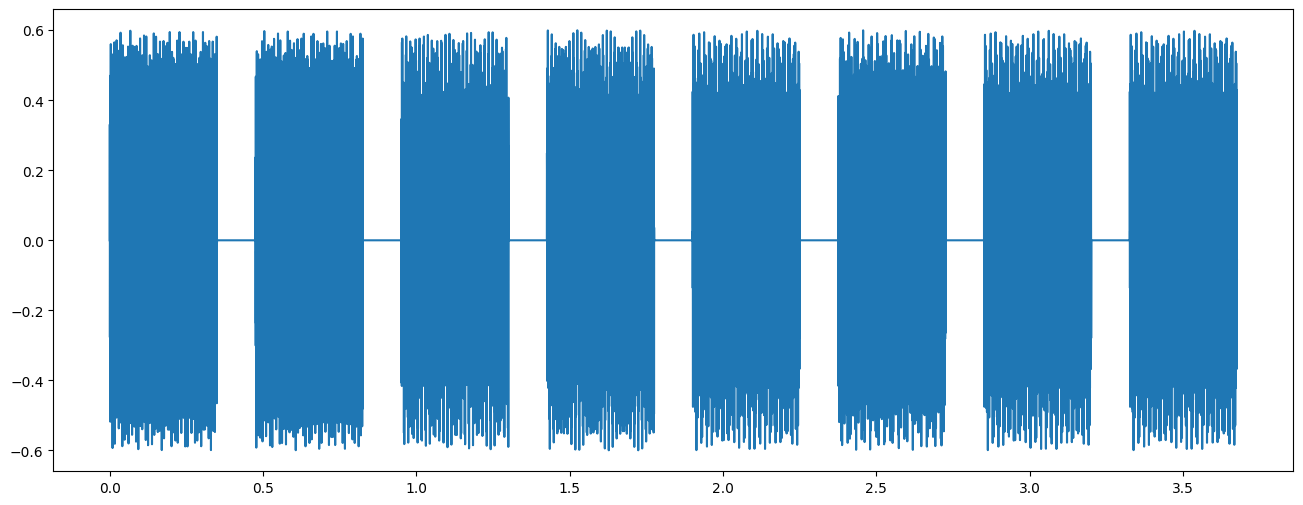

In [19]:
fs_3110 = 3110
sinal_freq_3110 = sinal_dca(fs_3110)
time_3110 = np.arange(0, len(sinal_freq_3110)/fs_3110 , 1/fs_3110)
plt.figure(figsize=(16,6))
plt.plot(time_3110 , sinal_freq_3110)
plt.show()

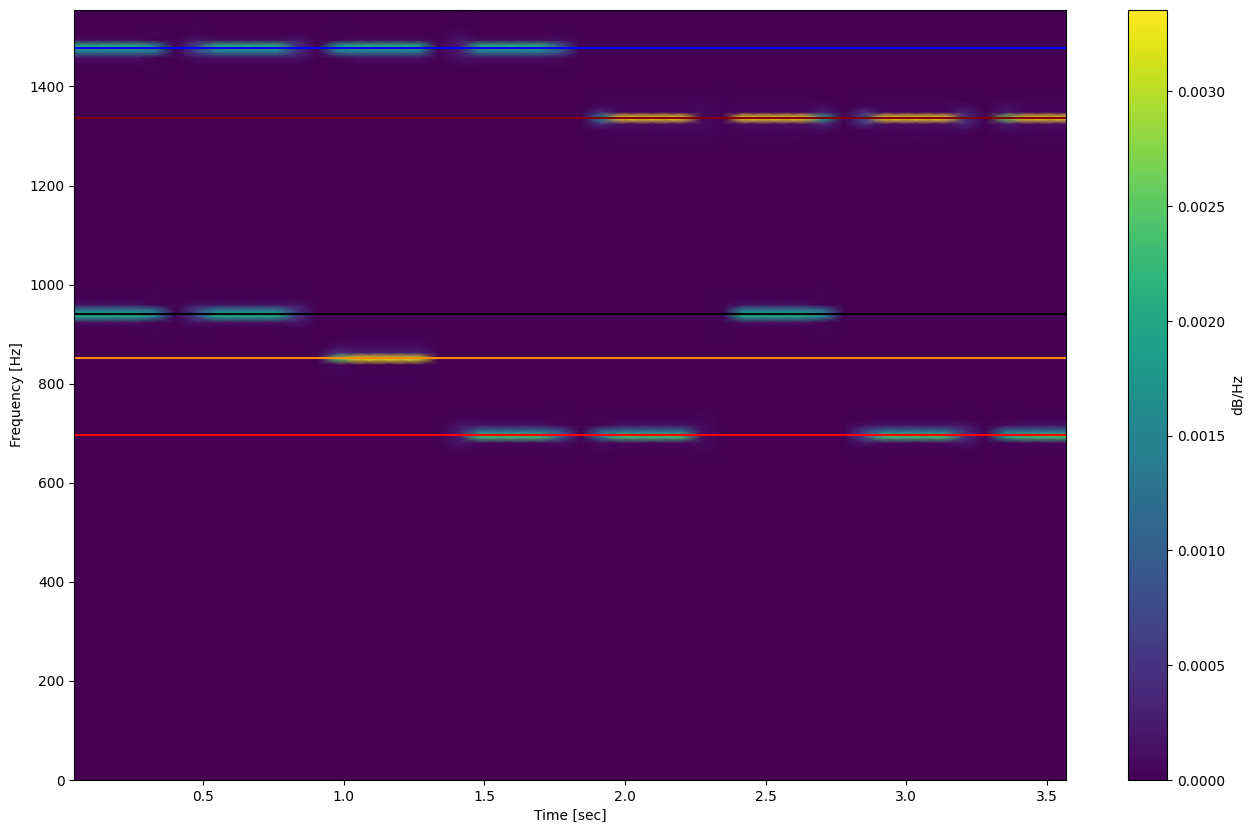

In [20]:
f, t, Sxx = sg.spectrogram(sinal_freq_3110, fs_3110)
plt.figure(figsize=(16,10))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.axhline(y=1477, xmin=0, xmax=len(sinal)*periodo , color='blue')
plt.axhline(y=1336, xmin=0, xmax=len(sinal)*periodo , color='#800000')
plt.axhline(y=941, xmin=0, xmax=len(sinal)*periodo , color='black')
plt.axhline(y=852, xmin=0, xmax=len(sinal)*periodo , color='#FF8C00')
plt.axhline(y=697, xmin=0, xmax=len(sinal)*periodo , color='red')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label="dB/Hz")
plt.show()

Com base nesse novo espectograma podemos perceber que os sinais de frequencias 1633Hz foram deslocados para a faixa de frequencia de 1477Hz.Com isso temos uma outra sequencia de teclas digitadas.

In [21]:
# Armazenando em um vetor as novas duplas de frequencias encontradas no spectograma
novas_frequencias_encontradas = np.array([
  [941,1477],
  [941,1477],
  [852,1477],
  [697,1477],
  [697,1336],
  [941,1336],
  [697,1336],
  [697,1336]])

novas_teclas_acionadas = []
for i in novas_frequencias_encontradas:
  novas_teclas_acionadas.append(encontrar_tecla(i[0],i[1]))

novas_teclas_acionadas # vetor contendo as teclas acionadas

['#', '#', '9', '3', '2', '0', '2', '2']

Como visto, a real sequencia de teclas que era #DCA2022 foi interpretada como ##932022 por conta da frequencia de amostragem não ter sido a ideal para amostrar esse sinal DTMF

<Figure size 640x480 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

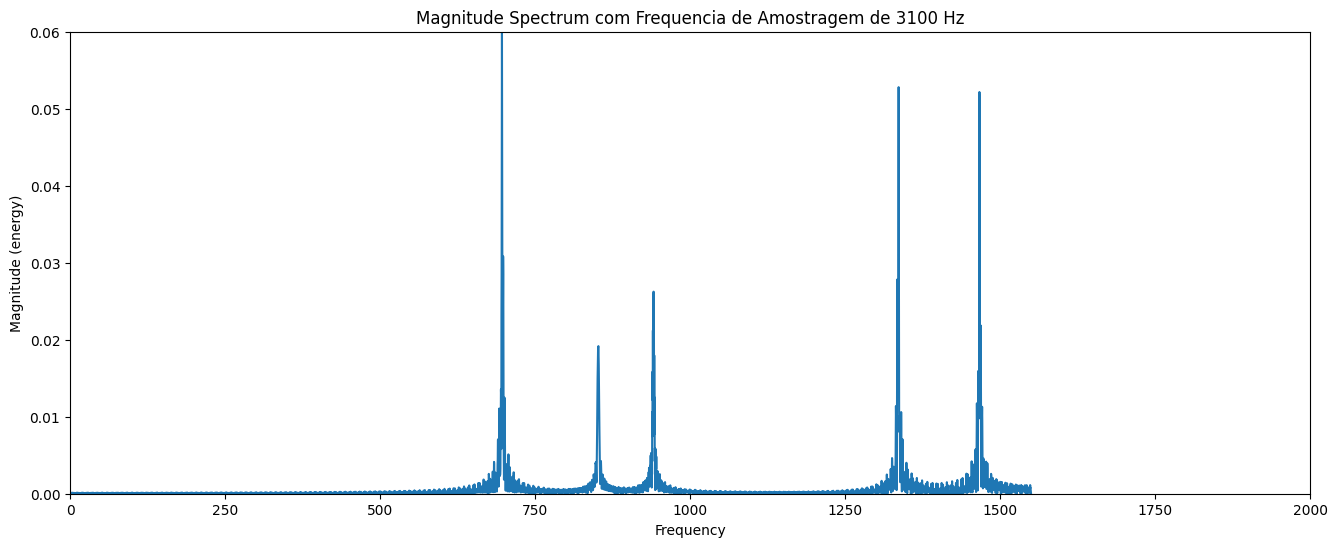

In [22]:
# Produzindo um gif mostrando a perda de informação e o surgimento de sinais com frquencias que nao existem
frames = [] # Aqui estarão contidas as imagens dos graficos gerados
cont = 1
for i in range(3280 , 3070 , -30):
  plt.clf() # Limpando alguma imagem antes de plotar a seguinte imagem
  plt.figure(figsize=(16,6))
  plt.magnitude_spectrum(sinal_dca(i),Fs=i)
  plt.title("Magnitude Spectrum com Frequencia de Amostragem de {} Hz".format(i))
  plt.xlim(0,2000)
  plt.ylim(0,0.06)
  plt.savefig('grafico{}.png'.format(cont))
  cont+=1

imgs = glob.glob("*.png")#Pegando o nome dos nossos arquivos de imagens e aramzenando no vetor imgs
for i in imgs:
  new_frame = Image.open(i)
  frames.append(new_frame) #Adicionando a imagem no vetor de frames
  
# Gerando nosso arquivo .gif através do nosso vetor de frames
frames[0].save('graficos.gif',  format='GIF' , append_images=frames[1:] , save_all=True , duration=500,Loop=0)


In [23]:
imgs

['grafico1.png',
 'grafico2.png',
 'grafico3.png',
 'grafico4.png',
 'grafico5.png',
 'grafico6.png',
 'grafico7.png']